In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
def PAUPprocess(filename): 
    with open(filename, 'r') as f: 
        lines = []
        m = False
        for line in f: 
            if 'charlabels' in line: 
                labels = line
            elif 'matrix' in line or m:
                m = True
                lines.append(line.rstrip())
            elif line == ';\n': 
                m = False
    lines = lines[1:-2]
    print("Length of Lines: ", len(lines))
    
    splitLabels = labels.split(" ")
    splitLabels[-1] = splitLabels[-1].rstrip().replace(';','')
    cleanLabels = splitLabels[1:]
    
    lines = [x.rstrip() for x in lines]
    linesDict = {}
    for val in lines: 
        splitVal = val.split(" ")
        if ';' in splitVal or '#nexus' in splitVal or 'begin' in splitVal or 'dimensions' in splitVal or 'matrix' in splitVal or 'end;' in splitVal: 
            continue
        else: 
            linesDict[splitVal[0]] = [int(y) for y in splitVal[1:]]
    
    df = pd.DataFrame(linesDict).T
    df.columns=cleanLabels
    df.loc["Total"] = df.sum()
    print(df.shape)
    
    return df

In [3]:
giPhyla = PAUPprocess("../paupFiles/run6-chosenPhyla/gi_choPhyla.nex")
oralPhyla = PAUPprocess("../paupFiles/run6-chosenPhyla/oral_choPhyla.nex")
giSpec = PAUPprocess("../paupFiles/run6-chosenPhyla/gi_choSpecies.nex")
oralSpec = PAUPprocess("../paupFiles/run6-chosenPhyla/oral_choSpecies.nex")

Length of Lines:  147
(148, 59)
Length of Lines:  51
(52, 25)
Length of Lines:  740
(741, 28373)
Length of Lines:  138
(139, 4338)


# Composition Labels of Bacteria Data

In [4]:
from Bio import Entrez

def EntrezSearch(searchTerm):
    Entrez.email = "vivek_ramanan@brown.edu" 
    Entrez.sleep_between_tries = 15
    Entrez.api_key = "f58d32928f53b067d24ec5ddee6c7a503b08"
    handle = Entrez.esearch(db="taxonomy",term=searchTerm,retmode = "xml")
    record = Entrez.read(handle)
    return record

def EntrezFetch(record, term):
    try: 
        searchID = record['IdList'][0]
    except:
        return "Fail"
    search = Entrez.efetch(id = searchID, db = "taxonomy", retmode = "xml")
    output = Entrez.read(search)
    return output

def compositionCheck(cleanLabels): 
    composition = {}
    lengths = {}
    for l in cleanLabels:
        record = EntrezSearch(l)
        output = EntrezFetch(record, l)
        if output == "Fail":
            continue
        else:
            try: 
                #print(l, output[0]['Division'])
                if output[0]['Division'] in composition:
                    composition[output[0]['Division']].append(l)
                    lengths[output[0]['Division']] += 1
                else:
                    composition[output[0]['Division']] = [l]
                    lengths[output[0]['Division']] = 1
            except:
                print("not found %s" %(output[0]['Division']))
                continue
                
    return list(lengths.keys()), list(lengths.values()), composition

In [5]:
gi_k, gi_v, gi_comp = compositionCheck(giPhyla.columns)
oral_k, oral_v, oral_comp = compositionCheck(oralPhyla.columns)

In [6]:
oral_k = ['Bacteria', 'Invertebrates', 'Viruses', 'Plants and Fungi', 'Phages']
oral_v = [10, 3, 10, 2, 0]

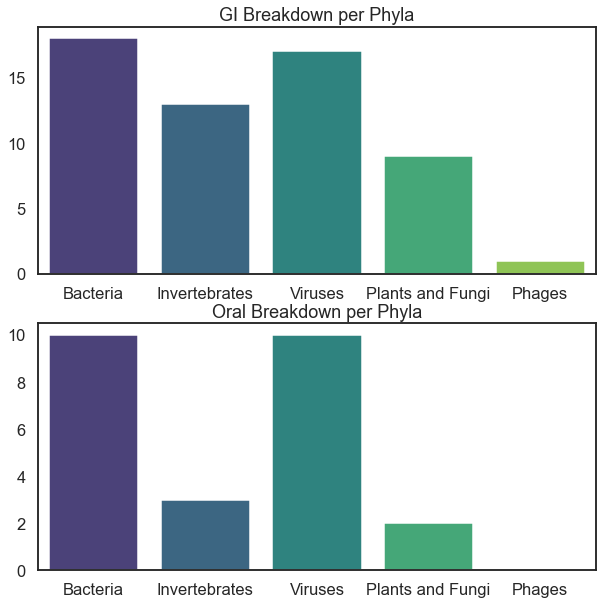

In [7]:
sns.set_style("white")
sns.set_context("talk")
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.barplot(ax=ax[0], x=gi_k,y=gi_v, palette="viridis")
sns.barplot(ax=ax[1], x=oral_k, y=oral_v, palette="viridis")
ax[0].set_title("GI Breakdown per Phyla")
ax[1].set_title("Oral Breakdown per Phyla")

#plt.savefig("../trees/run6-chosenPhyla/Figures/dataComposition.png")
plt.show()

# Pie Charts

In [16]:
dietDF = pd.read_csv("../hostUpdate-Current.csv")
carnivores = list(dietDF[dietDF['Diet'] == "C"]['Newick_label'])
herbivores = list(dietDF[dietDF['Diet'] == "H"]['Newick_label'])
omnivores = list(dietDF[dietDF['Diet'] == "O"]['Newick_label'])
fish = list(dietDF[dietDF['class'] == "Actinopteri"]['Newick_label'])
birds = list(dietDF[dietDF['class'] == "Aves"]['Newick_label'])
bats = list(dietDF[dietDF['order'] == "Chiroptera"]['Newick_label'])
giTotal = list(giPhyla.index.values[:-1])
oralTotal = list(oralPhyla.index.values[:-1])

#largeHerbivores = ["Camelus_dromedarius", "Buffalo", "Bubalus_bubalis", "Yak", "Oryctolagus_cniculus", "Bison_bison"]
largeHerbivores =["Ovis_aries", "Bos_taurus", "Capra_aegrarus_hircus", "Equus_caballus", "Giant_panda", "Marmota_himalayana",
                  "Camelus_dromedarius", "Buffalo", "Bubalus_bubalis", "Yak", "Oryctolagus_cniculus", "Bison_bison"]
primates = ["Pan_troglodytes", "Gorilla_gorilla", "Pan_paniscus", "Macaca_syvanus", "Papio_hamadryas", "Mandrillus_sphinx"]

bats = ["Myotis_nattereri", "Myotis_daubentonii", "Plecotus_auritus", "Nyctalus_noctula", "Miniopterus_schreibersii", \
        "Pipistrellus_pygmaeus", "Eptesicus_serotinus", "Hipposideros_armiger", "Taphozous_perforatus"]

domesticated = ["Homo_sapiens", "Sus_scrofa", "Bos_taurus", "Mus_musculus", "Ovis_aries", "Capra_aegrarus_hircus", \
               "Felis_catus", "Equus_caballus", "Canis_familiaris", "Gallus_gallus"]
rodents = []
humans = ["Homo_sapiens"]
dogs = ["Canis_familiaris"]
pigs = ["Sus_scrofa"]
cats = ["Felis_catus"]

gi_clades = {"Overall":giTotal, "Herbivores":herbivores, "Carnivores":carnivores, "Omnivores":omnivores, 
            "Large Herbivores":largeHerbivores, "Primates":primates, 
            "Domesticated": domesticated, "Humans": humans, "Dogs":dogs, "Pigs":pigs, "Cats":cats}
curious = {"Bats":bats, "Fish":fish, "Birds":birds}
# removed bats
oral_clades = {"Overall":oralTotal,"Herbivores":herbivores, "Carnivores":carnivores, "Omnivores":omnivores, 
               "Domesticated":domesticated, "Humans":humans, "Dogs":dogs, "Pigs":pigs, "Cats":cats}

In [15]:
taxonomyDict = {}
with open("../Data/taxonomyDict.txt", 'r') as f:
    for line in f:
        split = line.rstrip().split("\t")
        key = split[0]
        vals = split[1:]
        if "Sendai virus" in key:
            #print(key,flush=True)
            vals = ["genus:Respirovirus","family:Paramyxoviridae","order:Mononegavirales",\
                    "class:Monjiviricetes","phylum:Negarnaviricota","resolution:genus"]
        elif "Bastrovirus" in key:
            #print(key,flush=True)
            vals = ["family:Astroviridae","order:Stellavirales","class:Stelpaviricetes",\
                    "phylum:Pisuviricota","resolution:family"]
        keyDict = {}
        for value in vals:
            splitVal = value.split(":")
            keyDict[splitVal[0]] = splitVal[1]
        taxonomyDict[key] = keyDict
print(len(taxonomyDict))

def valueCountsSpecies(newDF, l, tax):
    df = newDF[newDF.index.isin(l)]
    df.loc["Total"] = df.sum()
    vals = {}
    totalNum = 0
    for i in range(len(df.loc["Total"])):
        if df.loc["Total"][i] > 0:
            spec = df.columns[i]
            spec = spec.replace("_", " ")
            if spec in taxonomyDict: 
                try: 
                    phylum = taxonomyDict[spec]["phylum"]
                except:
                    continue
                    #print(spec, taxonomyDict[spec])
                #print(spec, phylum)
                if phylum in vals: 
                    vals[phylum] += 1
                else:
                    vals[phylum] = 1
                totalNum += 1
    totalVals = {}
    otherVal = 0
    otherMakeup = []
    for key in vals.copy():
        percentage = 100*(float(vals[key]) / float(totalNum))
        if percentage <= 2.0:
            otherVal += vals[key]
            otherMakeup.append(key)
            vals.pop(key, None)
        totalVals[key] = percentage
    vals["Other"] = otherVal
    
    return vals, otherMakeup, totalVals 

def pieChart(data, label, cDict, other, tissueType):
    sns.set_context("paper")
    txt = "Other: " + ",".join(other)
    colors = []
    for key in data.keys():
        colors.append(cDict[key])
        
    fig1, ax1 = plt.subplots(figsize=(6,6))
    ax1.pie(data.values(), labels=data.keys(), colors=colors, autopct='%.0f%%', textprops={'fontsize': 11})
    ax1.set_title("Composition of %s" %(label), fontdict={'fontsize': 14})
    plt.tight_layout()
    print(txt)
    #plt.savefig("../trees/run6-chosenPhyla/Figures/" + tissueType + "_" + label + ".png", bbox_inches="tight")
    plt.show()
    return ax1

def colorDict(gi_comp, oral_comp):
    total = []
    for v in gi_comp.values():
        total += v
    for c in oral_comp.values():
        total += c
    total.append("Other")
    totalKeys = list(set(total))
    cmap = plt.get_cmap('Spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, len(totalKeys))]
    cDict = {}
    for i in range(len(totalKeys)):
        cDict[totalKeys[i]] = colors[i]
    return cDict
cDict = colorDict(gi_comp, oral_comp)

163905


## GI Clades

/Users/vivekramanan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Other: Fusobacteria,Negarnaviricota,Preplasmiviricota,Basidiomycota,Streptophyta,Microsporidia,Cossaviricota,Spirochaetes,Evosea,Uroviricota,Tenericutes,Ciliophora,Synergistetes,Kitrinoviricota,Lentisphaerae,Zoopagomycota,Chytridiomycota,Duplornaviricota,Parabasalia,Euryarchaeota,Artverviricota,Deferribacteres,Verrucomicrobia,Mucoromycota,Discosea,Phixviricota,Crenarchaeota,Chlamydiae,Fibrobacteres,Lenarviricota,Cercozoa,Chlorophyta,Cyanobacteria,Peploviricota,Deinococcus-Thermus,Fornicata,Euglenozoa,Oomycota,Chloroflexi,Elusimicrobia,Planctomycetes,Heterolobosea,Aquificae,Acanthocephala,Acidobacteria,Annelida,Tubulinea


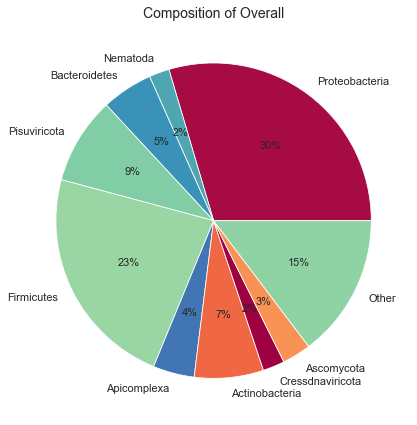

Other: Basidiomycota,Preplasmiviricota,Microsporidia,Negarnaviricota,Cossaviricota,Evosea,Ciliophora,Planctomycetes,Spirochaetes,Euryarchaeota,Mucoromycota,Duplornaviricota,Kitrinoviricota,Discosea,Phixviricota,Crenarchaeota,Artverviricota,Chlamydiae,Fibrobacteres,Fusobacteria,Cercozoa,Fornicata,Peploviricota,Parabasalia,Tenericutes,Deinococcus-Thermus,Aquificae,Synergistetes,Chloroflexi,Verrucomicrobia,Elusimicrobia,Uroviricota,Cyanobacteria,Euglenozoa,Lentisphaerae,Annelida,Zoopagomycota


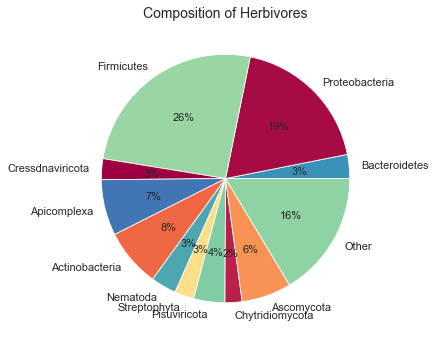

Other: Preplasmiviricota,Negarnaviricota,Discosea,Kitrinoviricota,Cyanobacteria,Duplornaviricota,Peploviricota,Basidiomycota,Deinococcus-Thermus,Spirochaetes,Tenericutes,Mucoromycota,Fusobacteria,Planctomycetes,Heterolobosea,Streptophyta,Chlamydiae,Microsporidia,Artverviricota,Fornicata,Acidobacteria,Parabasalia


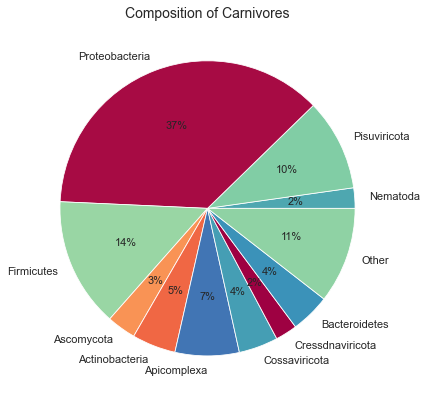

Other: Fusobacteria,Negarnaviricota,Basidiomycota,Streptophyta,Cressdnaviricota,Preplasmiviricota,Uroviricota,Tenericutes,Ciliophora,Cossaviricota,Synergistetes,Kitrinoviricota,Lentisphaerae,Zoopagomycota,Duplornaviricota,Parabasalia,Euryarchaeota,Artverviricota,Deferribacteres,Evosea,Verrucomicrobia,Chytridiomycota,Mucoromycota,Tubulinea,Chlamydiae,Lenarviricota,Phixviricota,Chlorophyta,Fornicata,Euglenozoa,Oomycota,Microsporidia,Chloroflexi,Deinococcus-Thermus,Cercozoa,Elusimicrobia,Peploviricota,Fibrobacteres,Cyanobacteria,Planctomycetes,Acanthocephala,Acidobacteria,Heterolobosea


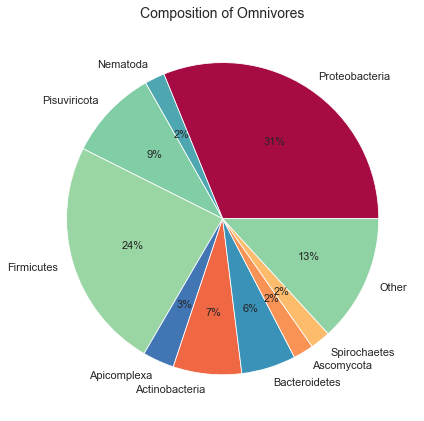

Other: Microsporidia,Negarnaviricota,Evosea,Streptophyta,Cressdnaviricota,Euryarchaeota,Spirochaetes,Mucoromycota,Duplornaviricota,Kitrinoviricota,Discosea,Crenarchaeota,Fibrobacteres,Cossaviricota,Fusobacteria,Cercozoa,Fornicata,Peploviricota,Parabasalia,Chlamydiae,Basidiomycota,Preplasmiviricota,Tenericutes,Planctomycetes,Aquificae,Synergistetes,Chloroflexi,Artverviricota,Verrucomicrobia,Elusimicrobia,Uroviricota,Cyanobacteria,Lentisphaerae,Annelida


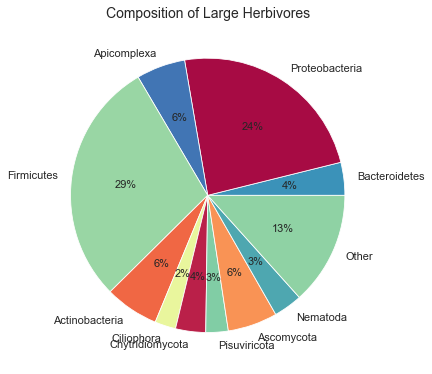

Other: Actinobacteria,Artverviricota,Spirochaetes,Evosea,Proteobacteria,Fornicata,Peploviricota,Ciliophora,Kitrinoviricota


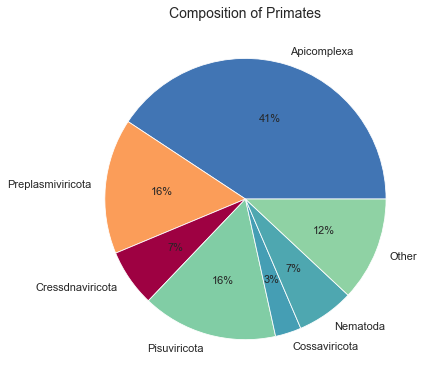

Other: Nematoda,Negarnaviricota,Basidiomycota,Streptophyta,Cressdnaviricota,Microsporidia,Fusobacteria,Evosea,Tenericutes,Ciliophora,Cossaviricota,Synergistetes,Kitrinoviricota,Lentisphaerae,Zoopagomycota,Chytridiomycota,Preplasmiviricota,Duplornaviricota,Uroviricota,Parabasalia,Deferribacteres,Verrucomicrobia,Mucoromycota,Euryarchaeota,Discosea,Crenarchaeota,Chlamydiae,Fibrobacteres,Lenarviricota,Phixviricota,Cercozoa,Chlorophyta,Peploviricota,Fornicata,Artverviricota,Euglenozoa,Oomycota,Chloroflexi,Deinococcus-Thermus,Elusimicrobia,Planctomycetes,Aquificae,Acanthocephala,Cyanobacteria,Acidobacteria


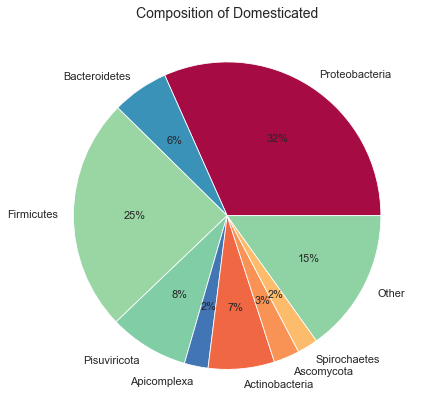

Other: Apicomplexa,Negarnaviricota,Basidiomycota,Streptophyta,Cressdnaviricota,Fusobacteria,Tenericutes,Cossaviricota,Kitrinoviricota,Lentisphaerae,Nematoda,Uroviricota,Preplasmiviricota,Evosea,Spirochaetes,Verrucomicrobia,Phixviricota,Euryarchaeota,Duplornaviricota,Fornicata,Artverviricota,Chytridiomycota,Euglenozoa,Parabasalia,Chlamydiae,Oomycota,Chloroflexi,Deinococcus-Thermus,Planctomycetes,Mucoromycota,Microsporidia,Ciliophora,Peploviricota,Acanthocephala,Cyanobacteria


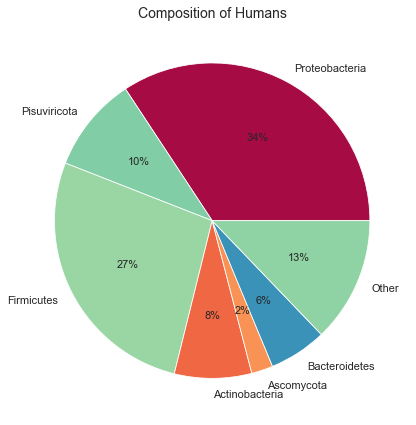

Other: Cressdnaviricota,Preplasmiviricota,Chlamydiae,Spirochaetes,Chlorophyta,Duplornaviricota,Negarnaviricota,Basidiomycota,Microsporidia,Parabasalia,Zoopagomycota,Fornicata,Peploviricota,Euglenozoa,Mucoromycota


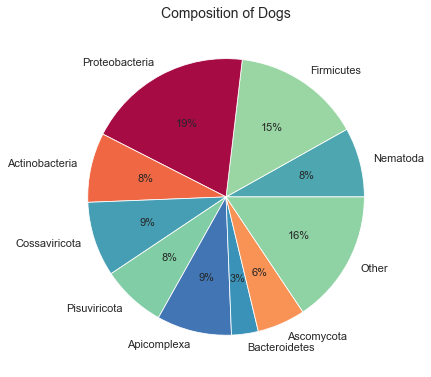

Other: Lentisphaerae,Preplasmiviricota,Evosea,Negarnaviricota,Apicomplexa,Duplornaviricota,Chlamydiae,Nematoda,Fusobacteria,Deferribacteres,Kitrinoviricota,Parabasalia,Ascomycota,Tenericutes,Fibrobacteres,Euryarchaeota,Synergistetes,Basidiomycota,Verrucomicrobia,Microsporidia,Fornicata,Elusimicrobia,Acanthocephala,Ciliophora


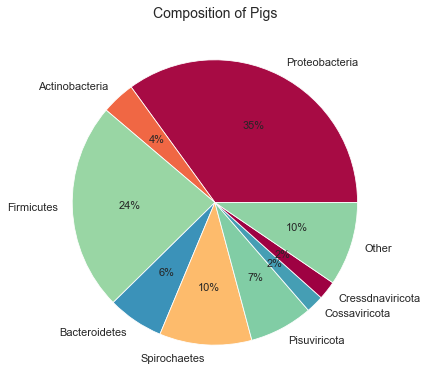

Other: Preplasmiviricota,Duplornaviricota,Peploviricota,Cressdnaviricota,Kitrinoviricota,Basidiomycota,Microsporidia,Fornicata,Artverviricota,Parabasalia,Ascomycota


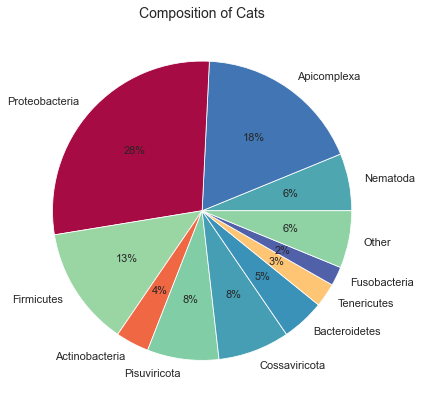

In [17]:
gi_Dict = {}
for clade in gi_clades: 
    temp, other, totalTemp = valueCountsSpecies(giSpec, gi_clades[clade], taxonomyDict)
    pieChart(temp, clade, cDict, other, "gi")
    gi_Dict[clade] = totalTemp

## Oral Clades

Other: Cressdnaviricota,Ascomycota,Tenericutes,Cossaviricota,Synergistetes,Chlamydiae,Peploviricota,Nematoda,Preplasmiviricota,Artverviricota,Parabasalia,Apicomplexa,Mucoromycota,Chloroflexi,Streptophyta,Euryarchaeota,Euglenozoa,Basidiomycota,Duplornaviricota,Deinococcus-Thermus,Kitrinoviricota,Cyanobacteria,Discosea,Acidobacteria,Evosea


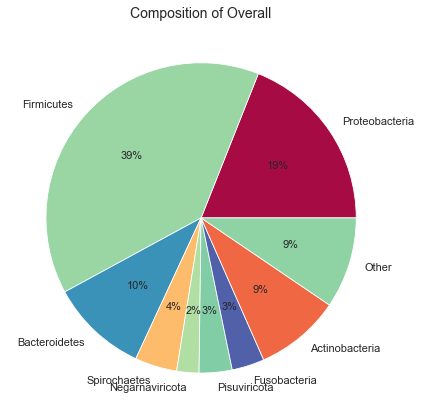

Other: Duplornaviricota,Kitrinoviricota,Cressdnaviricota,Basidiomycota,Artverviricota,Actinobacteria,Parabasalia,Spirochaetes


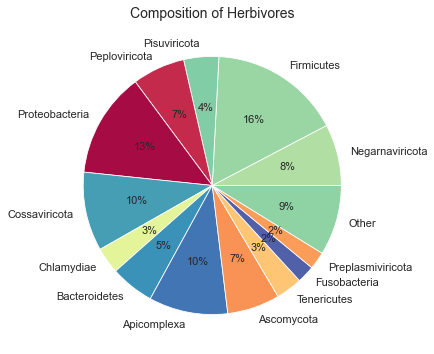

Other: Fusobacteria,Actinobacteria,Basidiomycota,Kitrinoviricota


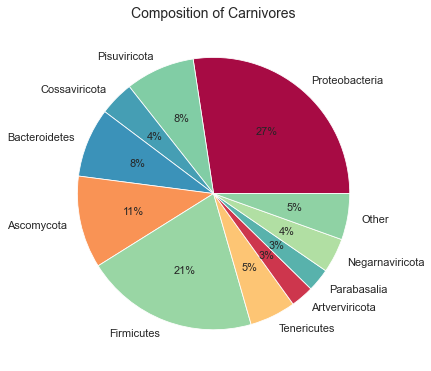

Other: Cressdnaviricota,Ascomycota,Tenericutes,Synergistetes,Cossaviricota,Chlamydiae,Nematoda,Peploviricota,Preplasmiviricota,Parabasalia,Mucoromycota,Chloroflexi,Streptophyta,Euryarchaeota,Artverviricota,Euglenozoa,Apicomplexa,Deinococcus-Thermus,Kitrinoviricota,Cyanobacteria,Discosea,Acidobacteria,Evosea,Basidiomycota


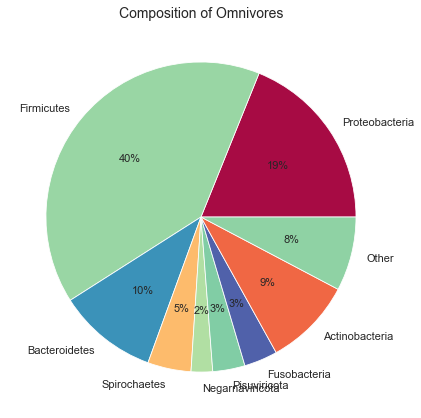

Other: Cressdnaviricota,Ascomycota,Tenericutes,Synergistetes,Cossaviricota,Chlamydiae,Nematoda,Peploviricota,Preplasmiviricota,Artverviricota,Parabasalia,Apicomplexa,Mucoromycota,Chloroflexi,Streptophyta,Euryarchaeota,Euglenozoa,Duplornaviricota,Deinococcus-Thermus,Kitrinoviricota,Cyanobacteria,Discosea,Acidobacteria,Evosea


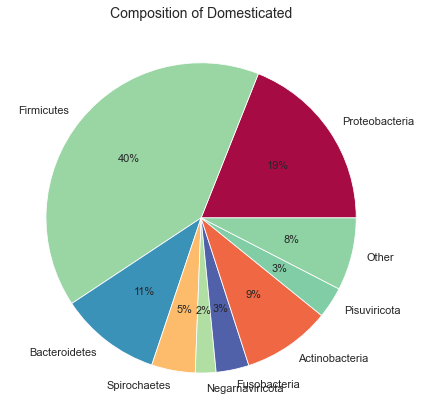

Other: Ascomycota,Tenericutes,Synergistetes,Chlamydiae,Nematoda,Peploviricota,Preplasmiviricota,Cossaviricota,Parabasalia,Mucoromycota,Streptophyta,Euryarchaeota,Artverviricota,Euglenozoa,Deinococcus-Thermus,Kitrinoviricota,Cyanobacteria,Discosea,Acidobacteria,Evosea,Chloroflexi


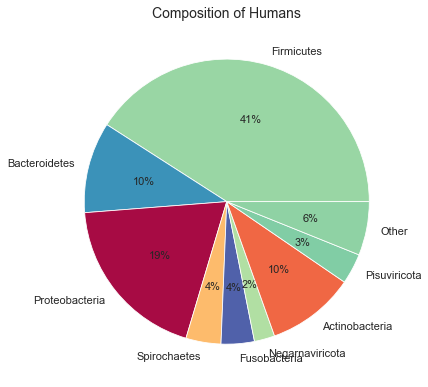

Other: Cossaviricota,Pisuviricota,Chloroflexi,Parabasalia,Negarnaviricota


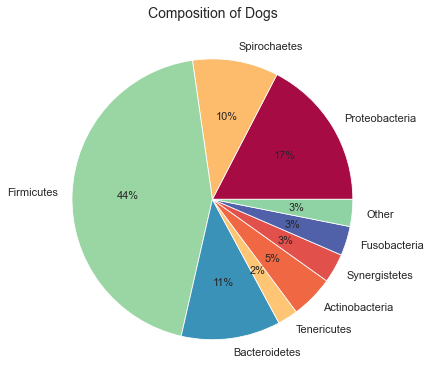

Other: Apicomplexa,Peploviricota,Parabasalia,Fusobacteria,Nematoda


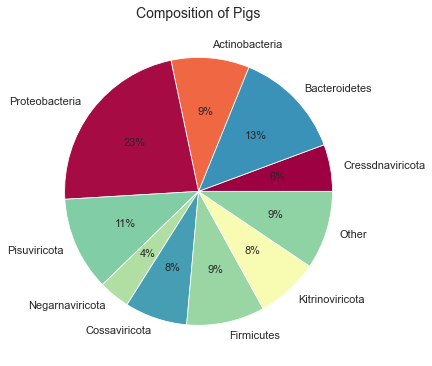

Other: 


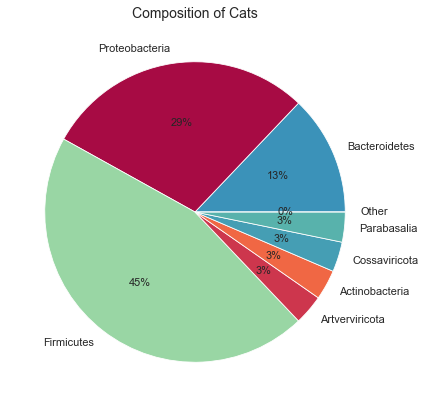

In [18]:
oral_Dict = {}
for clade in oral_clades: 
    temp, other, totalTemp = valueCountsSpecies(oralSpec, oral_clades[clade], taxonomyDict)
    pieChart(temp, clade, cDict, other, "oral")
    oral_Dict[clade] = totalTemp

# Extra Pie Charts

Other: 


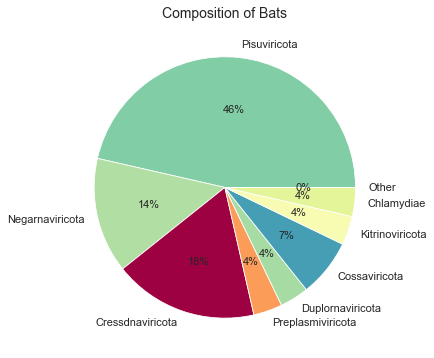

Other: Fusobacteria,Tubulinea,Discosea,Ciliophora,Basidiomycota,Ascomycota,Tenericutes,Deinococcus-Thermus,Cercozoa,Mucoromycota,Heterolobosea,Streptophyta,Apicomplexa,Chloroflexi,Negarnaviricota,Nematoda,Spirochaetes,Verrucomicrobia,Cossaviricota,Fornicata,Acidobacteria,Acanthocephala,Cyanobacteria,Duplornaviricota


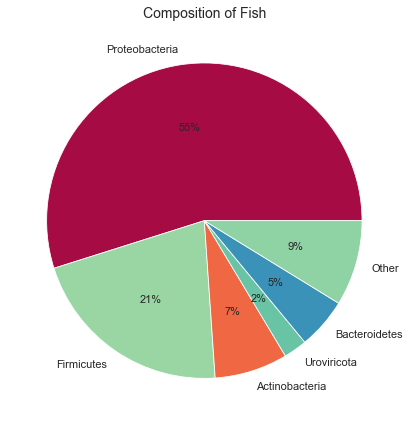

Other: Synergistetes,Duplornaviricota,Parabasalia,Spirochaetes,Chlamydiae,Kitrinoviricota,Negarnaviricota,Microsporidia,Tenericutes,Fusobacteria,Artverviricota,Elusimicrobia,Fornicata,Peploviricota,Ascomycota,Euryarchaeota,Basidiomycota,Oomycota,Uroviricota,Verrucomicrobia,Streptophyta


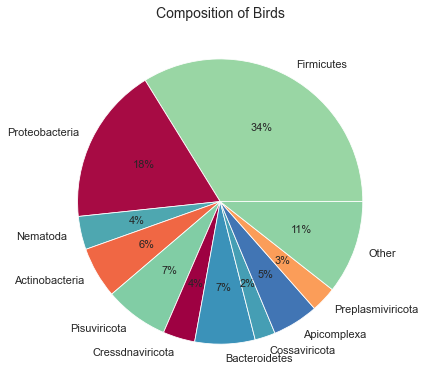

In [19]:
for clade in curious: 
    temp, other, totalTemp = valueCountsSpecies(giSpec, curious[clade], taxonomyDict)
    pieChart(temp, clade, cDict, other, "gi")

# Graph Experimentation

In [20]:
gi_df = pd.DataFrame(gi_Dict).fillna(0)
gi_df = gi_df.rename_axis('Phylum').reset_index()

oral_df = pd.DataFrame(oral_Dict).fillna(0)
oral_df = oral_df.rename_axis('Phylum').reset_index()

gi_df

,Phylum,Overall,Herbivores,Carnivores,Omnivores,Large Herbivores,Primates,Domesticated,Humans,Dogs,Pigs,Cats
0,Proteobacteria,29.572261,18.693467,37.001595,31.141199,23.825227,1.796407,31.658291,34.269324,19.375,34.989429,28.350515
1,Nematoda,2.074748,3.316583,2.232855,2.074908,3.380049,6.586826,1.693653,0.875604,8.125,1.162791,6.185567
2,Bacteroidetes,5.257922,3.115578,4.306220,5.644452,3.874691,0.000000,5.955704,5.917874,3.125,6.342495,4.639175
3,Pisuviricota,8.910047,4.070352,10.047847,9.389836,2.638087,15.568862,8.375209,9.782609,7.500,7.188161,7.731959
4,Firmicutes,22.978542,25.628141,14.194577,24.002110,28.936521,0.000000,24.530058,27.083333,15.000,23.572939,12.886598
5,Fusobacteria,0.582635,0.351759,0.797448,0.562687,0.494641,0.000000,0.632794,0.754831,0.000,0.317125,2.061856
6,Apicomplexa,4.234759,7.286432,7.017544,3.270617,5.770816,40.718563,2.493951,0.966184,8.750,1.268499,18.041237
7,Actinobacteria,7.091090,7.587940,4.784689,7.086337,6.347898,1.796407,6.960730,7.910628,8.125,3.805497,3.608247
8,Negarnaviricota,0.667898,0.804020,1.275917,0.685775,0.494641,0.000000,0.409455,0.241546,0.625,0.528541,0.000000
9,Preplasmiviricota,1.762115,1.608040,0.797448,1.600141,0.412201,15.568862,1.340034,1.419082,1.250,0.422833,0.515464


In [32]:
def barChart(df, groups, mostDataCol, title):
    data_df = df[groups]
    data_df = data_df[(data_df != 0).all(1)]
    data_df = pd.melt(data_df, id_vars="Phylum", var_name="Clade", value_name="Phyla Percentage")

    data_df = data_df[data_df['Phyla Percentage'] != 0.0]
    order = data_df[data_df['Clade'] == mostDataCol].sort_values("Phyla Percentage", ascending=False).Phylum
    
    sns.set_context("talk")
    sns.set_style("white")
    fig,ax = plt.subplots(1,1,figsize=(20, 10))
    ax = sns.barplot(ax=ax, data=data_df, x="Phylum", y="Phyla Percentage", 
                     order=order.values,
                     hue="Clade", palette=["C2", "C1", "C0"])
    ax.legend(loc='lower right')
    ax.set_title(title)
    plt.xticks(rotation = 50, fontsize=12)
    #plt.savefig("../trees/run6-chosenPhyla/Figures/" + title + ".png")
    plt.show()
    return

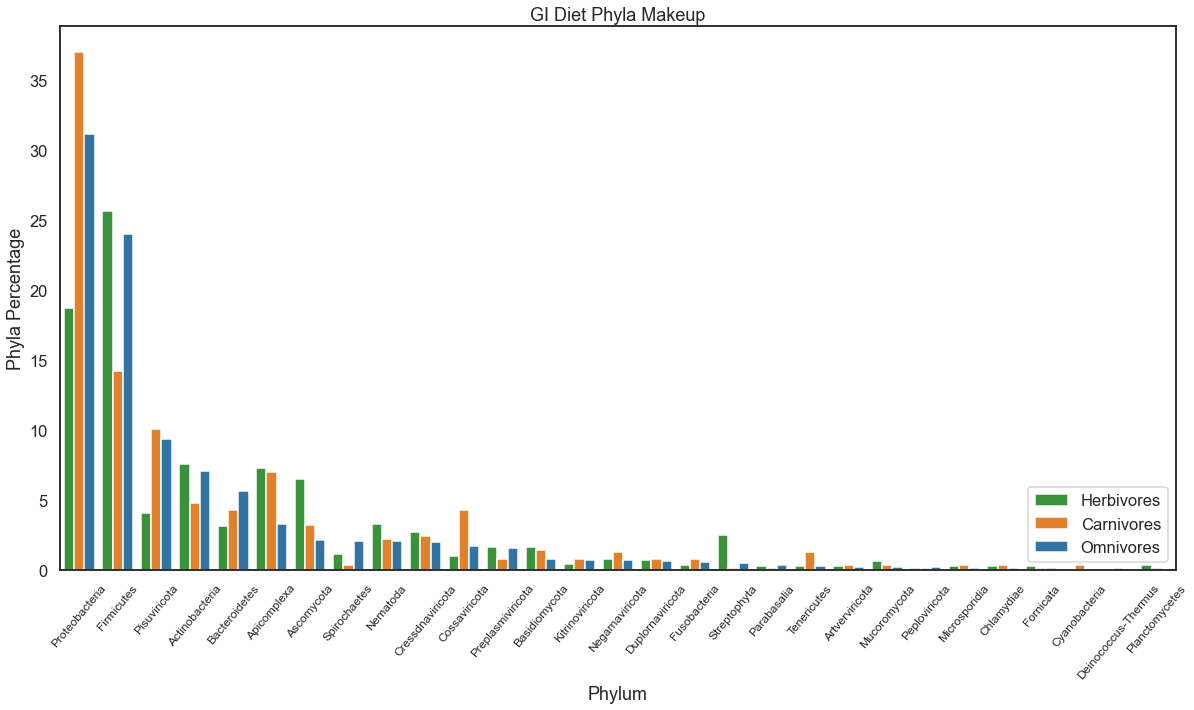

In [33]:
barChart(gi_df, ["Phylum", "Herbivores", "Carnivores", "Omnivores"], "Omnivores", "GI Diet Phyla Makeup")

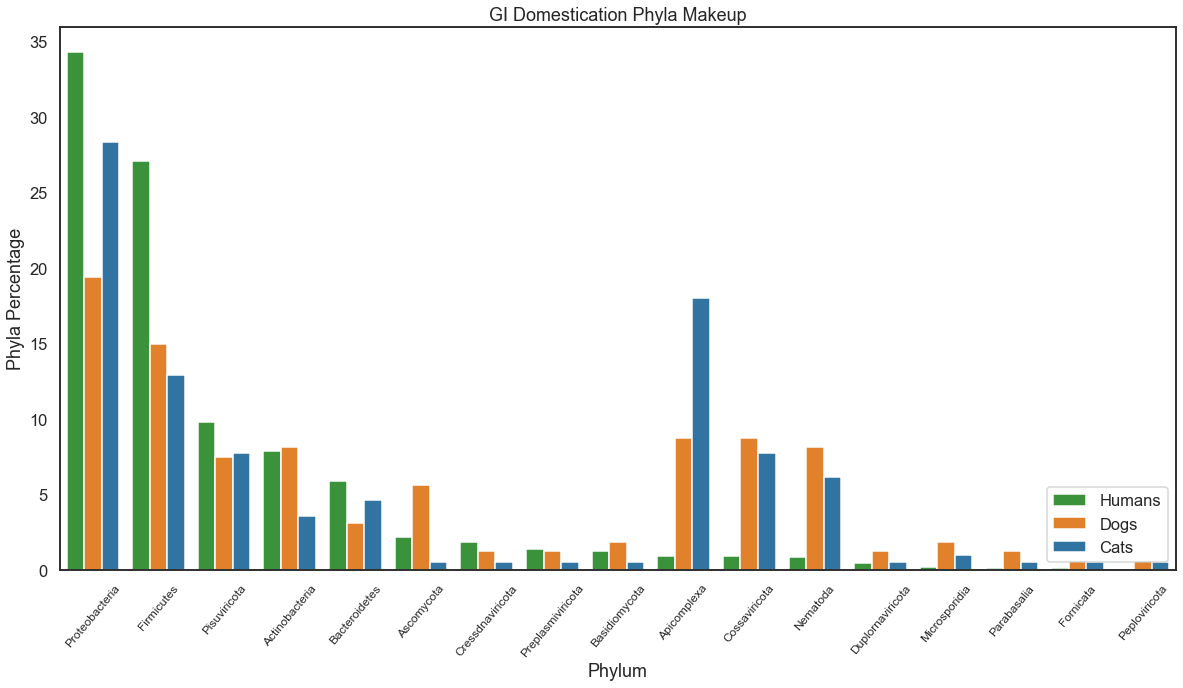

In [34]:
barChart(gi_df, ["Phylum", "Humans", "Dogs", "Cats"], "Humans", "GI Domestication Phyla Makeup")

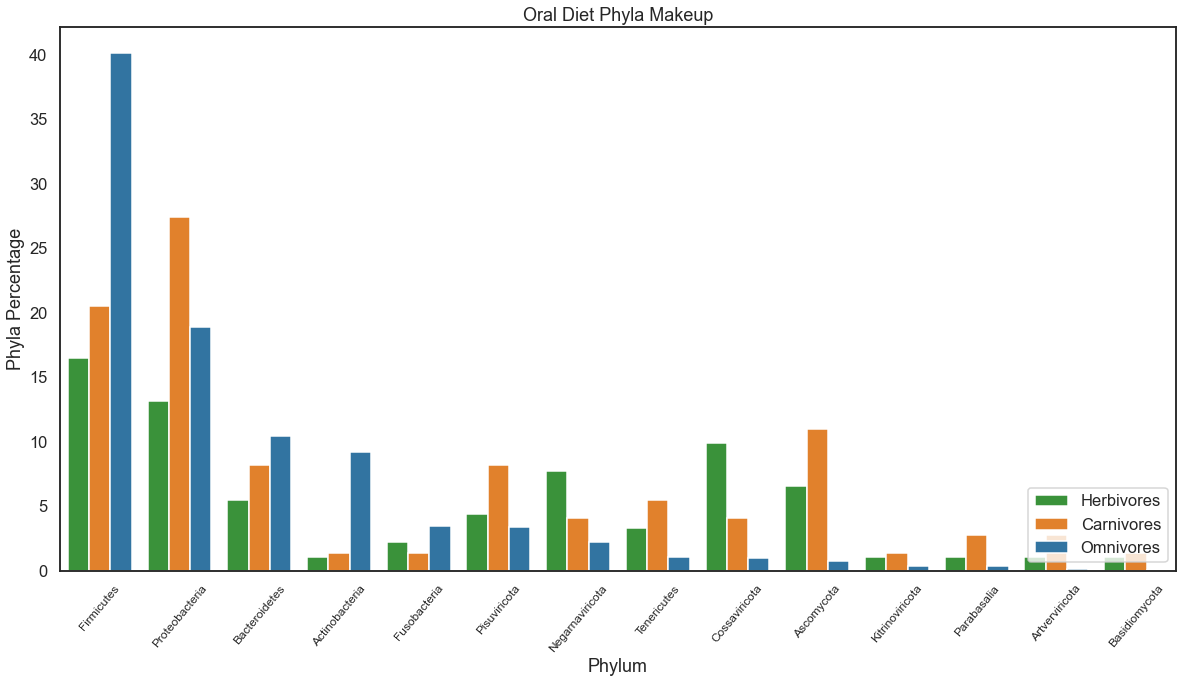

In [35]:
barChart(oral_df, ["Phylum", "Herbivores", "Carnivores", "Omnivores"], "Omnivores", "Oral Diet Phyla Makeup")